### IMPORT LIBRARIES

In [15]:
import os
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

### LOAD DATA

In [2]:
base_dir= "DATA"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

classes = ['melanoma', 'seborrheic_keratosis', 'nevus']

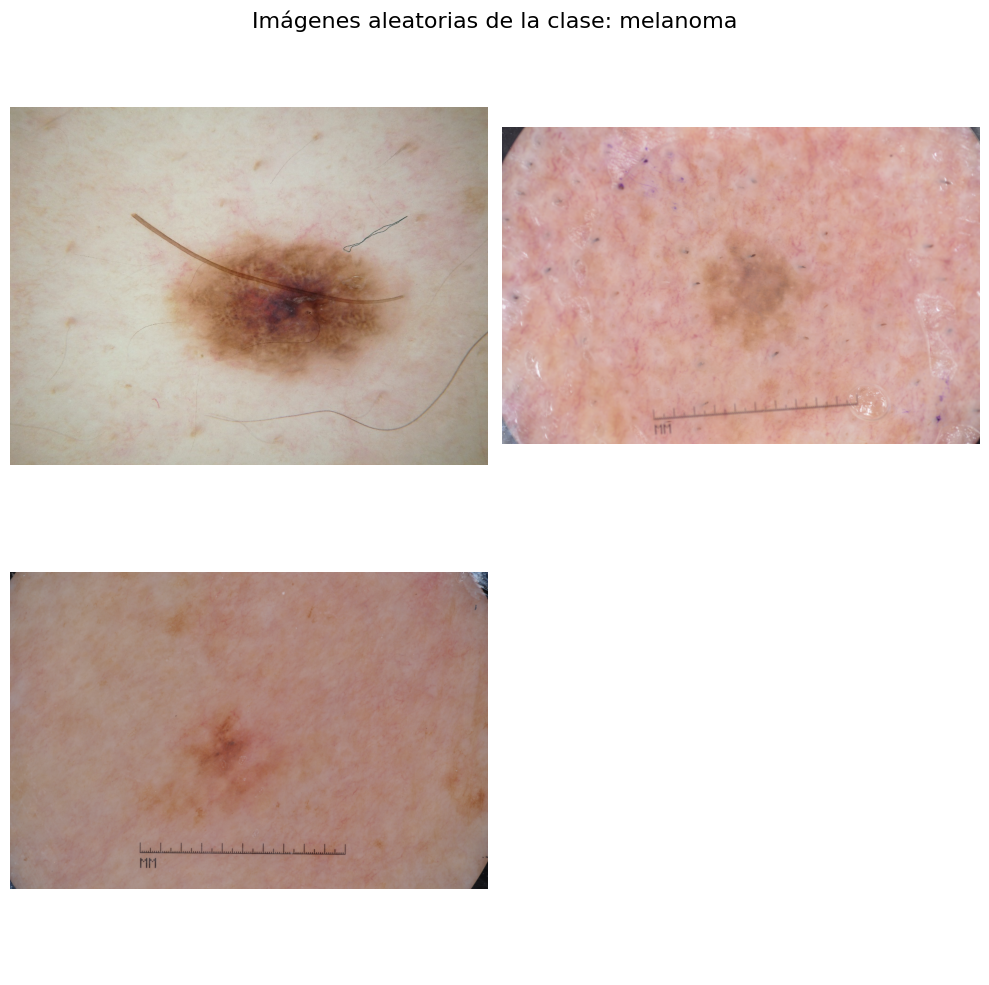

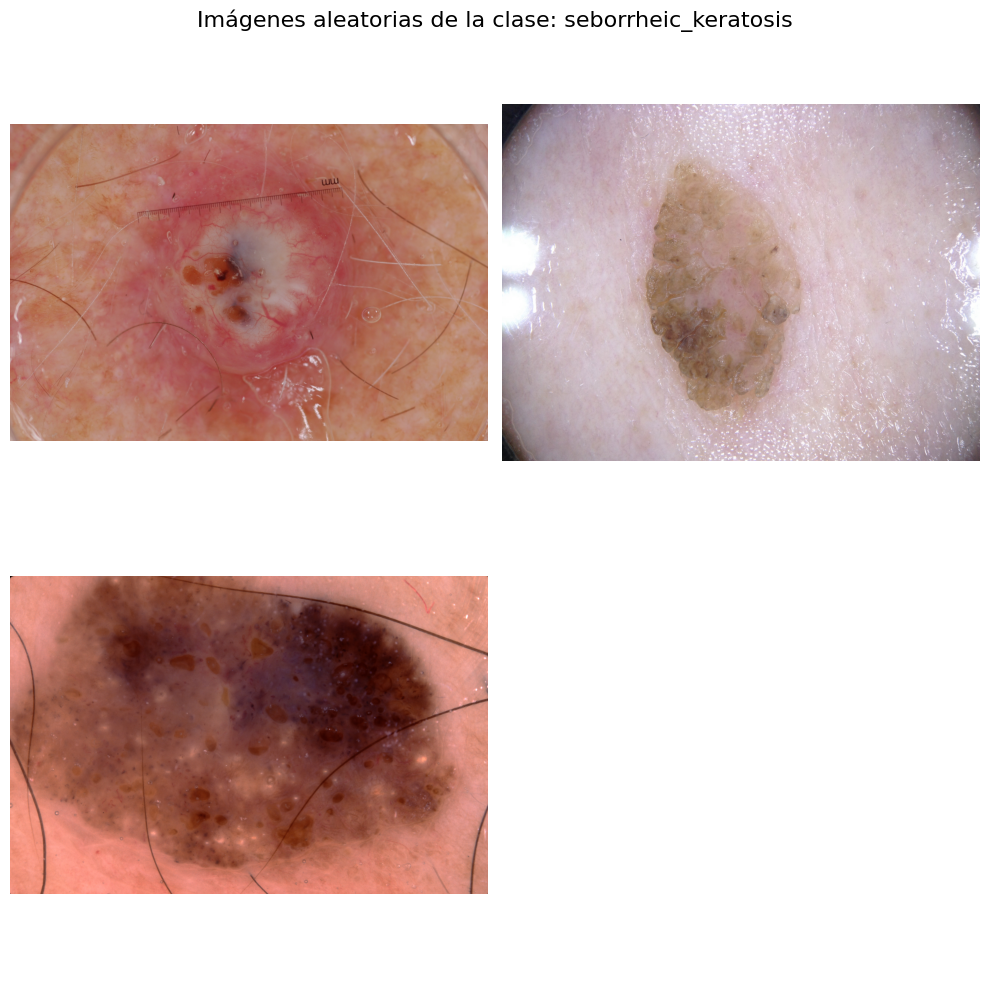

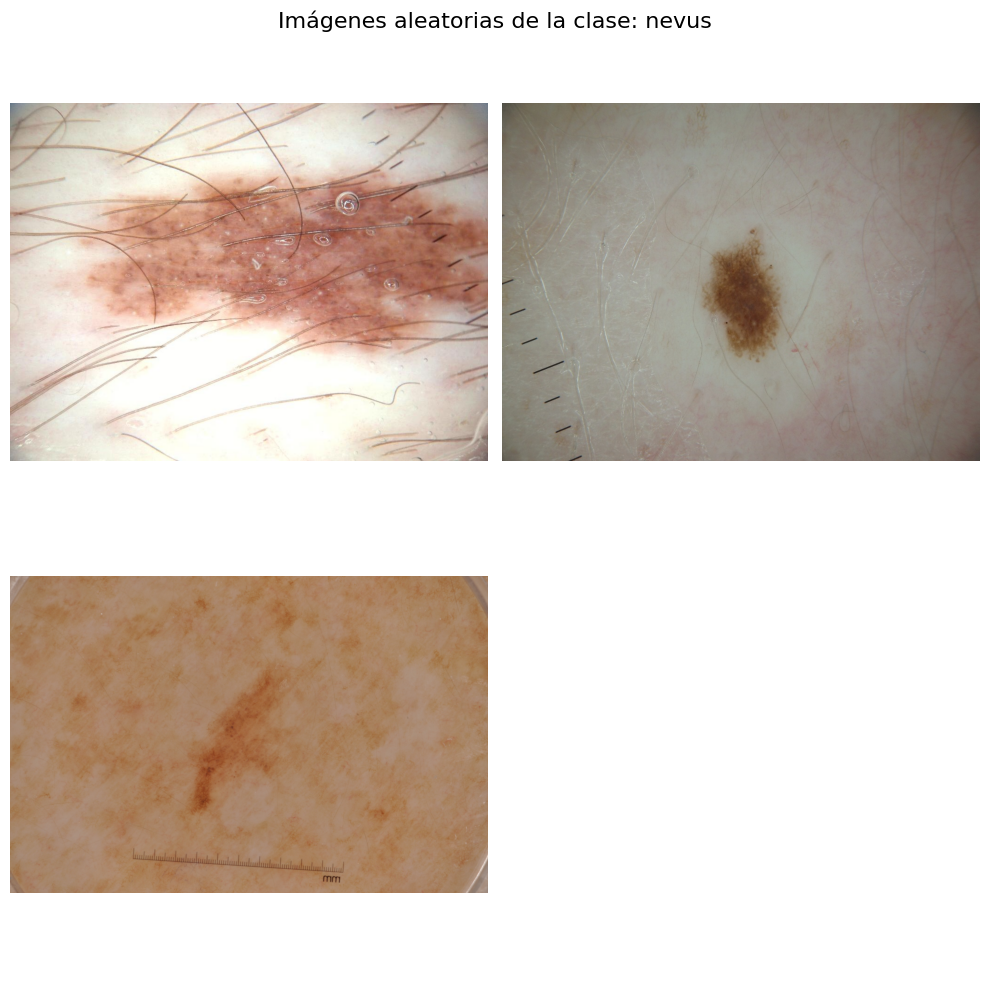

In [ ]:

def mostrar_imagenes_aleatorias(directory, class_name, n: int = 3):
    """
    Muestra n imágenes aleatorias de la carpeta  dentro de 'directory'
    en un grid cuadrado lo más compacto posible.
    """
    class_path = os.path.join(directory, class_name)
    todas = os.listdir(class_path)
    muestrario = random.sample(todas, min(n, len(todas)))

    cols = math.ceil(math.sqrt(len(muestrario)))
    rows = math.ceil(len(muestrario) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.flatten()            
    for ax, img_name in zip(axes, muestrario):
        img_path = os.path.join(class_path, img_name)
        ax.imshow(load_img(img_path))
        ax.axis("off")

    for ax in axes[len(muestrario):]:
        ax.axis("off")

    fig.suptitle(f"Imágenes aleatorias de la clase: {class_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Ejecución para todas las clases
for class_name in classes:
    mostrar_imagenes_aleatorias(train_dir, class_name)


### TAMAÑO DE LAS IMAGENES

In [10]:
image_sizes = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    image_sizes.append(img.size)

image_sizes = np.array(image_sizes)
mean_size = np.mean(image_sizes, axis = 0)
std_size = np.std(image_sizes, axis = 0)

print(f"Mean Image Size: {mean_size}")
print(f"Standard Deviation of Image Sizes: {std_size}")

Mean Image Size: [2301.33333333 1674.33333333]
Standard Deviation of Image Sizes: [1044.95911669  686.82862168]


La alta desviación en las dimensiones de las imágenes indica que unas son mucho más grandes o pequeñas que otras; esto importa porque:

1. Las CNN solo aceptan tensores de tamaño fijo, así que cada lote tendrá que redimensionarse o rellenarse, introduciendo distorsiones o desperdiciando memoria. 
2. Los objetos de interés abarcarán proporciones distintas del encuadre según el tamaño original, dificultando que el modelo aprenda patrones coherentes.
3. Los gradientes y la velocidad de entrenamiento varían con el número de píxeles, lo que puede sesgar la optimización.

Para solucionar este problema redimensionamos todas las fotos al mismo tamaño para que el modelo siempre tenga las imágenes iguales. Luego, solo en el entrenamiento, las giramos un poco, las acercamos o las desplazamos para que practique con versiones variadas y aprenda a reconocer la lesión aunque cambie ligeramente. En cambio, en validación y prueba dejamos las imágenes tal cual para comprobar de forma justa lo que el modelo ha aprendido.

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)


val_test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, 
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False
)

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


### BALANCEO DE LAS CLASES

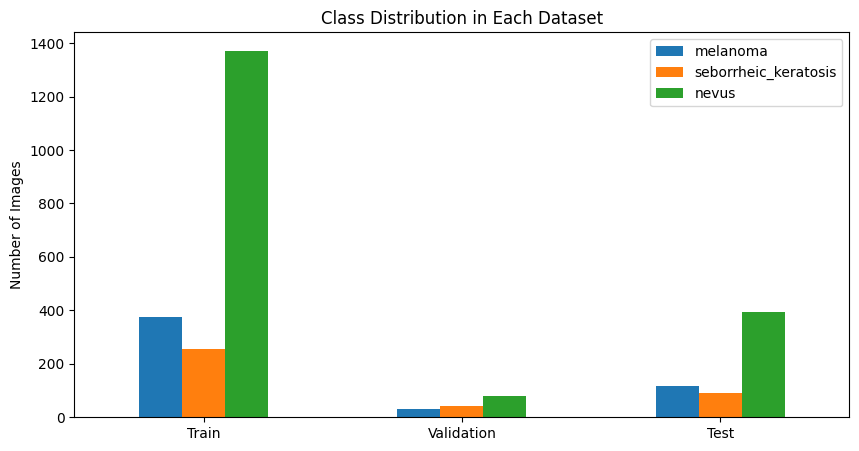

In [21]:
def count_images(directory):
    class_counts = {}
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images
    return class_counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

df = pd.DataFrame([train_counts, val_counts, test_counts], index = ['Train', 'Validation', 'Test'])
df.plot(kind = 'bar', figsize = (10,5))
plt.title('Class Distribution in Each Dataset')
plt.ylabel('Number of Images')
plt.xticks(rotation = 0)
plt.show()


In [ ]:
df = pd.DataFrame([train_counts, val_counts, test_counts], index=['Train', 'Validation', 'Test'])
df_pct = df.div(df.sum(axis=1), axis=0) * 100                   
print("\nPorcentaje de cada clase:")
print(df_pct)



Porcentaje de cada clase:
            melanoma  seborrheic_keratosis  nevus
Train           18.7                  12.7   68.6
Validation      20.0                  28.0   52.0
Test            19.5                  15.0   65.5


Para compensar el desbalanceo entre clases, y evitar que el modelo favorezca la mayoritaria, usamos class_weight, que asigna a cada etiqueta un peso inversamente proporcional a su frecuencia (las menos representadas reciben un valor mayor). El vector resultante se convierte luego en un diccionario {clase: peso} para pasarlo a model.fit y lograr que todas las clases influyan por igual en el entrenamiento.

In [ ]:
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(train_generator.classes),
    y = train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

Para arreglar el balanceo de clase Reducimos la clase nevus hasta quedar con el mismo número de imágenes que la segunda clase mayoritaria para poder eliminar el desbalance sin perder diversidad. Así evitamos que el modelo se incline hacia la clase dominante y, al mismo tiempo, mantenemos suficiente información de nevus para que aprenda sus patrones.

# NO CORRER hasta ver si vamos a hacerlo o no

In [ ]:
import pathlib, shutil

#ROOT = pathlib.Path("DATA/train")  
KEEP_RATIO = 1.0                   

melanoma_dir   = ROOT / "melanoma"
nevus_dir      = ROOT / "nevus"
discarded_dir  = nevus_dir.parent / "_discarded"
discarded_dir.mkdir(exist_ok=True)

n_melanoma = len(list(melanoma_dir.glob("*")))
nevus_imgs = sorted(nevus_dir.glob("*"))                # orden fijo
max_nevus  = int(n_melanoma * KEEP_RATIO)
keep_nevus = nevus_imgs[:max_nevus]                     # mismas siempre
drop_nevus = nevus_imgs[max_nevus:]


#for img in drop_nevus:
    #shutil.move(str(img), discarded_dir / img.name)     # usa os.remove() para borrar

print(f"Conservadas {len(keep_nevus)} imágenes de nevus.")
print(f"Descartadas {len(drop_nevus)} → {discarded_dir}")

# Guardar la lista para control de versiones
with open("nevus_kept.txt", "w", encoding="utf-8") as f:
    f.writelines(f"{p.name}\n" for p in keep_nevus)
print("Lista de imágenes conservadas guardada en nevus_kept.txt")


Conservadas 374 imágenes de nevus.
Descartadas 998 → DATA\train\_discarded
Lista de imágenes conservadas guardada en nevus_kept.txt


In [20]:
df = pd.DataFrame([train_counts, val_counts, test_counts], index=['Train', 'Validation', 'Test'])
df_pct = df.div(df.sum(axis=1), axis=0) * 100                   
print("\nPorcentaje de cada clase:")
print(df_pct)


Porcentaje de cada clase:
             melanoma  seborrheic_keratosis      nevus
Train       37.325349             25.349301  37.325349
Validation  20.000000             28.000000  52.000000
Test        19.500000             15.000000  65.500000
